# Figure 1: Hyperbolic learning dynamics, loss surface and gradient descent paths for linear denoising autoencoders. 

This notebook provides the code to produce Figure 1 in the paper: "Learning dynamics of linear denoising autoencoders". (ICML 2018)

### Learning dynamics equation

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from collections import OrderedDict

# custom imports
from src.scalar_net.scalar_linear_net import ScalarNeuralNetwork
from src.scalar_net.optimisers import gradient_descent
from src.scalar_net.visualisations import plot_learning_dynamics 
from src.scalar_net.visualisations import plot_optimiser_trajectory_3d
from src.scalar_net.visualisations import plot_mse_loss_surface_3d
from src.scalar_net.visualisations import plot_global_minimum_manifold_3d
from src.scalar_net.visualisations import plot_weight_norm


# define hyperbolic dynamics equation function
def hyperbolic_dae_dynamics(l, v, n_epoch, learning_rate, w1_init, w2_init):
    dynamics = []
    c0 = np.abs(w2_init**2 - w1_init**2)
    theta0 = np.arcsinh(2*(w2_init*w1_init)/c0)
    vl = (1+(v/l))
    g = np.sqrt(c0**2*(vl**2) + 4)
    tau = 1/learning_rate
    for t in range(n_epoch):
        E = np.exp(g*l*t/tau)
        num = (1-E)*(g**2 - c0**2*(vl**2) \
                     - 2*c0*vl*np.tanh(theta0/2)) \
                     - 2*(E+1)*g*np.tanh(theta0/2)
        denom = (1-E)*(2*c0*vl + 4*np.tanh(theta0/2)) - 2*(E+1)*g
        thetaf = 2*np.arctanh(num/denom)
        uf = 0.5*c0*np.sinh(thetaf)
        dynamics.append(uf)
    return dynamics

### Simulation study

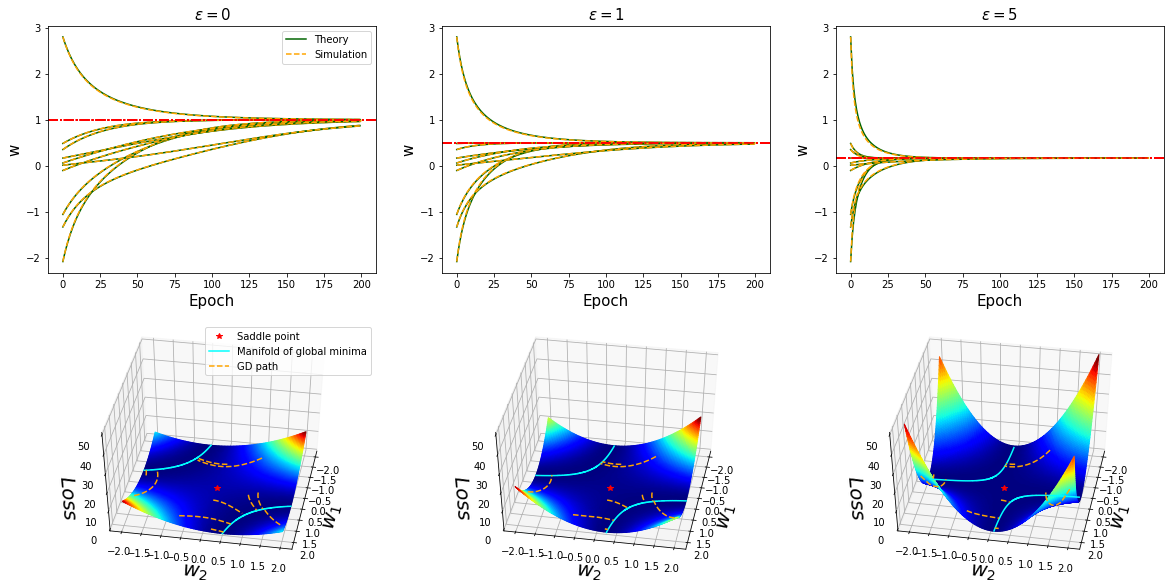

In [2]:
num_trials = 10
histories = []
weights = {'w1':[], 'w2':[]}
x = 1
lams = [1] 
sigmas = [0, 1, 5]
l2 = 0
epochs = 200
lr = 0.01

fig = plt.figure(figsize = (20,10))

ax1 = fig.add_subplot(234, projection='3d')
ax2 = fig.add_subplot(231, )
ax3 = fig.add_subplot(235, projection='3d')
ax4 = fig.add_subplot(232, )
ax5 = fig.add_subplot(236, projection='3d')
ax6 = fig.add_subplot(233, )
axes = [[ax1, ax2], [ax3, ax4], [ax5, ax6]]
count = 0

for l in lams:
    for v in sigmas:
        ax_1 = axes[count][0]
        ax_2 = axes[count][1]
        ax_1, settings = plot_mse_loss_surface_3d(ax_1, x, l, v, l2, angle=45)
        plot_global_minimum_manifold_3d(ax_1, settings)
        ax_2.set_xlabel('Epoch', fontsize=10)
        ax_2.set_ylabel('$w_2 \cdot w_1$', fontsize=10)
        histories = []
        for t in range(num_trials):
            np.random.seed(t*2)
            w1 = np.random.uniform(-2, 2)
            w2 = np.random.uniform(-2, 2)

            scalarNet = ScalarNeuralNetwork(seed=t)
            scalarNet.optimiser(gradient_descent)
            scalarNet.initialiser(w1=w1, w2=w2)
            scalarNet.train(x, y=l, n_epoch=epochs, learning_rate=lr, v=v, 
                            l2=l2, verbose=False)
            histories.append(scalarNet.history)
            weights['w1'].append(w1)
            weights['w2'].append(w2)
            
            # plot optimiser trajectory (remove duplicate labels and add legend)
            plot_optimiser_trajectory_3d(ax_1, settings, histories[t], 
                                         c='orange', ls='--', label='GD path')
            if count == 0:
                handles, labels = ax_1.get_legend_handles_labels()
                by_label = OrderedDict(zip(labels, handles))
                ax_1.legend(by_label.values(), by_label.keys(), loc='upper right')
    
            # plot theoretical dynamics (remove duplicate labels and add legend)
            dynamics = hyperbolic_dae_dynamics(l, v, epochs, lr, 
                                               weights['w1'][t], weights['w2'][t])
            ax_2.plot(dynamics, label='Theory', c='darkgreen')
            if count == 0:
                handles, labels = ax_2.get_legend_handles_labels()
                by_label = OrderedDict(zip(labels, handles))
                ax_2.legend(by_label.values(), by_label.keys(), loc='upper right')
            ax_2.set_title('$\epsilon = $' + str(v), fontsize=15)
            
            # empirical dynamics
            plot_learning_dynamics(ax_2, histories[t], label='Simulation', c='orange', ls='--')
            ax_2.set_ylabel('w', fontsize=15)
            ax_2.set_xlabel('Epoch', fontsize=15)
            ax_2.axhline(y=l/(l+v), color='r', linestyle='-.')
        count += 1
plt.show()

**Top**: Hyperbolic learning dynamics for each simulated run (dashed orange lines) together with the theoretically predicted learning dynamics (solid green lines). The red line in each plot indicates the final value of the resulting fixed point solution $w^*$. 

**Bottom**: The loss surface corresponding to the loss $\ell_\lambda = \frac{\lambda}{2}(1 - w_2w_1)^2 + \frac{\varepsilon}{2}(w_2w_1)^2$ for $\lambda = 1$, as well as the gradient descent paths (dashed orange lines) for randomly initialised weights. The cyan hyperbolas represent the global minimum loss manifold that corresponds to all possible combinations of $w_2$ and $w_1$ that minimise $L$. 

**Left**: $\varepsilon = 0, w^* = 1$. **Middle**: $\varepsilon = 1, w^* = 0.5$. **Right**: $\varepsilon = 5, w^* = 1/6$.